In [3]:

import numpy as np
import matplotlib.pyplot as plt
# import cvxpy as cp 
from scipy import optimize
from scipy.linalg import toeplitz
from numpy import fft 
from core.core import *
from util.detector import * 
from util.estimator import * 
from util.modem import * 

import random
import os 

### The Maximum Likelihood detection

In [4]:
def ml(y_re, H_re, symbol_space, snr_dB):
    """
    Maximum Likelihood detection for KxN mu-MIMO channel (uses Gaussian distribution) 
    """
    # complex to real and then reshape for broadcast
    snr = 10**(snr_dB/20)
    T = H_re.shape[0]
    K = H_re.shape[-1] // 2
    M = int(symbol_space.shape[0] ** (1/K))
    x_shape = tuple([T, K, 1])
    symbol_space_re = np.hstack((symbol_space.real, symbol_space.imag)) * np.ones(shape=(T, M**K, 2*K))
    likelihood = phi(np.matmul(symbol_space_re, H_re.transpose(0, 2, 1)) * y_re.transpose(0, 2, 1) * np.sqrt(2 * snr))
    log_likelihood = np.sum(np.log(likelihood), axis=2)
    x_hat_idx = np.argmax(log_likelihood, axis=1)
    x_hat_ML = np.take(symbol_space, x_hat_idx, axis=0)
    x_hat_ML = x_hat_ML.reshape(x_shape)
    return x_hat_ML 

In [3]:

K = 2   # Number of users (transmitter antenna) 
N = 4   # Number of Receiver (Receive antenna)
M = 4   # level of modulation (4-QAM / QPSK)
T = 10 # Total Transmission rounds 
SNR_max = 30


def make_symbol_space(K, M, cp):
    """
    Makes symbol space S = |M|^K 
    :params: 
    :   K (int) : number of users\n
    :   M (int) : level of modulation\n
    :returns:
    :   symbol_space (np.ndarray) : symbol space S=|M|^K
    """
    index_space = np.indices([M for _ in range(K)]).reshape(K, -1).T 
    symbol_space = np.take(cp, index_space)
    return symbol_space 

def comp2re(H, x, z, y):
    """
    Real representation of complex matrix \n
    \t x = [x_r + j x_i] --->  x_re = [x_re x_im] \n
    \t H_re = \n \t \t[H_real, -H_imag \n
        \t H_imag, H_real]\n
    
    """
    x_re = np.hstack((x.real, x.imag))
    z_re = np.hstack((z.real, x.imag))
    y_re = np.hstack((y.real, y.imag)) 
    H_re = np.block([
        [H.real, -H.imag],
        [H.imag, H.real]
    ])
    return H_re, x_re, z_re, y_re 

snr = 5

# simple constellation points (normalized)
constellation_points = np.array([-1-1j, -1+1j, 1-1j, 1+1j])
constellation_points /= np.sqrt(2) 

# make symbol space = |M|^K  in case of using ML detection 
symbol_space = make_symbol_space(K, M, cp=constellation_points) 

x = np.random.randint(0, M, size=K * T).reshape(T, K, 1) 
x = np.take(constellation_points, x)

# Channel 
H = (1 / np.sqrt(2)) * (np.random.randn(T, N, K) + 1j * np.random.randn(T, N, K))
z = (1 / np.sqrt(2)) * (np.random.randn(T, N, 1) + 1j * np.random.randn(T, N, 1))

r = np.matmul(H, x) + (10**(-snr/20)) * z  

# 1-bit ADC 
y = np.sign(r.real) + 1j * np.sign(r.imag) 

H_re, x_re, z_re, y_re = comp2re(H, x, z, y)

In [4]:
x_re[0]

array([[ 0.70710678],
       [-0.70710678],
       [ 0.70710678],
       [ 0.70710678]])

In [5]:
# H_re_tilde
H_re_tilde = H_re * y_re 
H_re_tilde.shape

(10, 8, 4)

In [16]:
rho = 5

nominator = np.exp(-rho * np.square((H_re_tilde @ x_tilde)))
denominator = phi(np.sqrt(2 * rho) * (H_re_tilde @ x_re))
grad = (1/np.sqrt(2 * np.pi)) * (nominator / denominator) 
def compute_grad(x_tilde):
    rho = 5 
    nominator = np.exp(-rho * np.square((H_re_tilde @ x_tilde)))
    denominator = phi(np.sqrt(2 * rho) * (H_re_tilde @ x_tilde))
    grad = (1 / np.sqrt(2 * np.pi)) * (nominator / denominator) 
    return grad 


NameError: name 'x_tilde' is not defined

### Near maximum Likelihood detection (Optimization method) 


In [18]:
# Initialize x_tilde for nML 
x_tilde = np.random.randn(T, 2*K, 1)

learning_rate = 0.01 

# for i in range(1):
#     x_tilde = x_tilde + learning_rate * (H_re_tilde.transpose(0, 2, 1) @ compute_grad(x_tilde=x_tilde))
    
#     if i % 10 == 0 : 
#         print()

In [13]:
x_tilde = np.random.randn(T, 2*K, 1) 

In [7]:
print(x_tilde[0])
snr_db = 5
snr = 10 ** (snr_db/20) 

denominator = phi(np.matmul(H_re_tilde, x_tilde) * np.sqrt(2 * snr))
nominator = np.exp(-snr * (np.matmul(H_re_tilde, x_tilde))**2)
grad = (1/np.sqrt(2 * np.pi)) * (nominator / denominator)
compute_grad = np.matmul(H_re_tilde.transpose(0, 2, 1), grad)

x_tilde = x_tilde + learning_rate * compute_grad
print(x_tilde[0])

def compute_grad(H_re_tilde, x_init, snr):
    denominator = phi(np.matmul(H_re_tilde, x_init) * np.sqrt(2 * snr))
    nominator = np.exp(-snr * (np.matmul(H_re_tilde, x_init))**2)
    grad = (1/np.sqrt(2 * np.pi)) * (nominator/denominator) 
    return np.matmul(H_re_tilde.transpose(0, 2, 1), grad)

def nML(y_re, H_re, x_init, symbol_space, snr_dB, iter=10):
    snr = 10 ** (snr_dB/20) 
    H_re_tilde = H_re * y_re 
    
    for _ in range(iter):
        x_init = compute_grad(H_re_tilde=H_re_tilde, x_init=x_init, snr=snr)
        print(x_init)

    return x_init



[[-0.61147772]
 [-0.92859158]
 [-0.38219352]
 [ 1.0309411 ]]
[[-0.60903339]
 [-0.94166278]
 [-0.33180756]
 [ 1.00831946]]


/Users/lab2020/opt/anaconda3/envs/learning/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


In [8]:
x_tilde = np.random.randn(T, 2*K, 1)
snr_db = 0

x_tilde = nML(y_re, H_re, x_tilde, symbol_space=constellation_points, iter=10, snr_dB=snr_db)

[[[-2.11166657]
  [-2.43025126]
  [ 1.83268067]
  [ 5.1901162 ]]

 [[-5.80632303]
  [-3.12043267]
  [-5.41257069]
  [-4.63484452]]

 [[ 0.72376527]
  [ 3.41528538]
  [-5.12906351]
  [ 7.79012336]]

 [[ 0.61025773]
  [-1.33844796]
  [-1.47288539]
  [ 1.50363583]]

 [[-1.21789586]
  [-2.78306307]
  [ 1.01127683]
  [ 1.74145343]]

 [[ 1.1210831 ]
  [-4.08127729]
  [-2.51034045]
  [ 0.00872845]]

 [[-1.05983458]
  [-4.34610864]
  [-0.12886598]
  [ 2.48453524]]

 [[ 1.19325161]
  [ 5.98089713]
  [ 1.44686539]
  [-0.56794544]]

 [[ 0.5049716 ]
  [ 1.51509158]
  [ 1.04982896]
  [-2.1868962 ]]

 [[ 3.71675518]
  [ 1.36148132]
  [-1.95178648]
  [ 0.04372072]]]
[[[ 0.46078162]
  [-1.15652493]
  [ 3.60944784]
  [-2.17403819]]

 [[ 6.13209834]
  [-1.96536358]
  [-0.97192246]
  [-0.54328267]]

 [[       -inf]
  [       -inf]
  [        inf]
  [       -inf]]

 [[-0.07565748]
  [-0.04907434]
  [-0.15469506]
  [ 0.09359318]]

 [[ 0.67330628]
  [ 1.12222298]
  [-2.09146321]
  [ 1.27230943]]

 [[ 1.3301

/Users/lab2020/opt/anaconda3/envs/learning/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/Users/lab2020/opt/anaconda3/envs/learning/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in matmul
  
/Users/lab2020/opt/anaconda3/envs/learning/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/Users/lab2020/opt/anaconda3/envs/learning/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [15]:
x= x_re[0] 
H = H_re[0] 
y = y_re[0]


In [16]:
x.shape, H.shape, y.shape

((4, 1), (8, 4), (8, 1))

In [17]:
x_init = np.random.randn(4, 1)

In [19]:
sers_avg = []
snrs = []
err = 0

In [318]:
def cost(G_tilde, x_init, snr):
    snr = 10 ** (snr/20) 
    g = np.sqrt(2 * snr) * (G_tilde @ x_init) 
    g = phi(g) 
    g = np.log(g) 
    g = np.sum(g) 
    return g

def compute_gradient(G_tilde, x_init, snr):
    snr = 10 ** (snr/20) 
    inner = G_tilde @ x_init 
    # print("inner product term:", inner)
    nom = inner ** 2
    nom = np.exp(-snr * nom) 
    # print("numerator", nom)
    denom = np.sqrt(2 * snr) * inner 
    denom = phi(denom)
    denom = np.clip(a=denom, a_min=0.001, a_max=None)
    # print("denominator: ", denom)
    grad = (1 / np.sqrt(2 * np.pi)) * (nom / denom) 
    grad = G_tilde.T @ grad 
    return grad

def GD(x_init, snr, epoch=10, lr=0.01):
    global G_tilde 
    costs = []
    for e in range(epoch):
        print(x_init.squeeze(), "-->", end=" ")
        x_init = x_init + lr * compute_gradient(G_tilde=G_tilde, x_init=x_init, snr=snr)
        print(x_init.squeeze())
        if np.linalg.norm(x_init) >= np.sqrt(K):
            x_init /= np.linalg.norm(x_init)
            x_init *= np.sqrt(K)
        costs.append(cost(G_tilde=G_tilde, x_init=x_init, snr=snr))
        # if e % 2 == 0 : 
        #     print("cost=", cost(G_tilde=G_tilde, x_init=x_init, snr=snr))
    return costs, x_init

def comp2re(H, x, z, y):
    x_re = np.vstack((x.real, x.imag))
    z_re = np.vstack((z.real, x.imag))
    y_re = np.vstack((y.real, y.imag)) 
    H_re = np.block([
        [H.real, -H.imag],
        [H.imag, H.real]
    ])
    return H_re, x_re, z_re, y_re 


trial = 1
snr_min = -10
snr_max = 30
snr_lst = np.arange(snr_min, snr_max+1, 5)
ser_avg = []

K = 2; N = 16; M = 4

constellation_points = np.array([-1-1j, -1+1j, 1-1j, 1+1j])
constellation_points /= np.sqrt(2) 

for snr in snr_lst:
    err = 0
    print(f"Trial snr : {snr}...", end=" ")
    for t in range(trial):
        x = np.random.randint(0, M, size=K).reshape(K, 1) 
        x = np.take(constellation_points, x)
        # Channel 
        H = (1 / np.sqrt(2)) * (np.random.randn(N, K) + 1j * np.random.randn(N, K))
        z = (1 / np.sqrt(2)) * (np.random.randn(N, 1) + 1j * np.random.randn(N, 1))

        r = np.matmul(H, x) + (10**(-snr/20)) * z  

        # 1-bit ADC 
        y = np.sign(r.real) + 1j * np.sign(r.imag) 

        H_re, x_re, z_re, y_re = comp2re(H, x, z, y)

        G_tilde = H_re * y_re 

        # x_init = np.random.randn(2*K, 1) 
        # x_init = np.zeros(shape=(2*K, 1))
        # x_init = x_init / np.linalg.norm(x_init)

        # add initialization
        num1 = np.matmul(G_tilde.T, np.ones_like(y_re))
        denom1 = np.linalg.norm(num1)
        x_init = (np.sqrt(K) * (num1 / denom1))
        _, x_tilde_re = GD(x_init=x_init, snr=snr, epoch=10, lr=0.02)
        x_tilde = x_tilde_re[:K] + 1j * x_tilde_re[K:]
        x_det_first_stage = symbol_by_symbol(x_tilde=x_tilde, constellation_points=constellation_points)
        # print("detected: ", x_det_first_stage.squeeze(), "label:", x.squeeze())
        err += (K - np.sum(np.isclose(x_det_first_stage, x)))
    print(f"ser: {err / (K*trial)}")
    ser_avg.append(err / (K*trial))

ser_avg = np.array(ser_avg)        
print(ser_avg)

Trial snr : -10... [-1.02981448 -0.60020628  0.59793748 -0.47085594] --> [-0.9875013  -0.56674991  0.570614   -0.42938825]
[-0.9875013  -0.56674991  0.570614   -0.42938825] --> [-0.94836122 -0.53625269  0.54539243 -0.3934656 ]
[-0.94836122 -0.53625269  0.54539243 -0.3934656 ] --> [-0.91226039 -0.50862896  0.52221593 -0.36247675]
[-0.91226039 -0.50862896  0.52221593 -0.36247675] --> [-0.87905686 -0.48374281  0.50100592 -0.33584425]
[-0.87905686 -0.48374281  0.50100592 -0.33584425] --> [-0.84860193 -0.46142492  0.48166676 -0.31303058]
[-0.84860193 -0.46142492  0.48166676 -0.31303058] --> [-0.82074175 -0.44148646  0.4640908  -0.29354279]
[-0.82074175 -0.44148646  0.4640908  -0.29354279] --> [-0.79531922 -0.42373012  0.44816301 -0.27693489]
[-0.79531922 -0.42373012  0.44816301 -0.27693489] --> [-0.77217597 -0.40795829  0.43376505 -0.26280824]
[-0.77217597 -0.40795829  0.43376505 -0.26280824] --> [-0.75115432 -0.39397897  0.42077847 -0.25081026]
[-0.75115432 -0.39397897  0.42077847 -0.25081

In [21]:
def make_symbol_space(K, M, cp):
    """
    Makes symbol space S = |M|^K 
    :params: 
    :   K (int) : number of users\n
    :   M (int) : level of modulation\n
    :returns:
    :   symbol_space (np.ndarray) : symbol space S=|M|^K
    """
    index_space = np.indices([M for _ in range(K)]).reshape(K, -1).T 
    symbol_space = np.take(cp, index_space)
    return symbol_space 

def comp2re(H, x, z, r):
    x_re = np.hstack((x.real, x.imag))
    z_re = np.hstack((z.real, x.imag))
    r_re = np.hstack((r.real, r.imag)) 
    H_re = np.block([
        [H.real, -H.imag],
        [H.imag, H.real]
    ])
    return H_re, x_re, z_re, r_re 

def initialize(G_tilde, y_re):
    num1 = np.matmul(G_tilde.transpose(0, 2, 1), np.ones_like(y_re))
    denom1 = np.linalg.norm(num1, axis=1).reshape(-1, 1, 1)
    x_init = (num1 / denom1) * np.sqrt(K)
    return x_init

def cost(G_tilde, x_init, snr):
    snr = 10 ** (snr/20) 
    g = np.sqrt(2 * snr) * (G_tilde @ x_init) 
    g = phi(g) 
    g = np.log(g) 
    g = np.sum(g, axis=1) 
    return g

def compute_gradient(G_tilde, x_init, snr):
    snr = 10 ** (snr/20) 
    inner = G_tilde @ x_init 
    # print("inner product term:", inner)
    nom = inner ** 2
    nom = np.exp(-snr * nom) 
    # print("numerator", nom)
    denom = np.sqrt(2 * snr) * inner 
    denom = phi(denom)
    denom = np.clip(a=denom, a_min=0.001, a_max=None)
    # print("denominator: ", denom)
    grad = (1 / np.sqrt(2 * np.pi)) * (nom / denom) 
    grad = G_tilde.transpose(0, 2, 1) @ grad 
    return grad

def GD(x_init, snr, epoch=100, lr=0.01):
    global G_tilde 
    costs = []
    for e in range(epoch):
        # print(x_init[0].squeeze(), '-->', end=' ')
        x_init += lr * compute_gradient(G_tilde=G_tilde, x_init=x_init, snr=snr)
        # print(x_init[0].squeeze())
        if np.linalg.norm(x_init) >= np.sqrt(K):
            x_init /= np.linalg.norm(x_init, axis=1).reshape(-1, 1, 1)
            x_init *= np.sqrt(K)
        costs.append(cost(G_tilde=G_tilde, x_init=x_init, snr=snr))
        # if e % 10 == 0 : 
        #     print(f"epoch {e}: cost=", np.around(cost(G_tilde=G_tilde, x_init=x_init, snr=snr).squeeze(), 2))
    return costs, x_init


trials = 100
K = 2; N = 16; T = int(1e4); M = 4

snr_min = -10 
snr_max = 30 
snr_lst = np.arange(snr_min, snr_max+1, 5)

constellation_points = np.array([-1-1j, -1+1j, 1-1j, 1+1j])
constellation_points /= np.sqrt(2) 

symbol_space = make_symbol_space(K, M, constellation_points)

sers_avg = np.zeros(shape=(len(snr_lst), 3)) 
x = np.random.randint(0, M, size=K * T).reshape(T, K, 1) 
x = np.take(constellation_points, x)
for t in range(trials):
    print(f"Trial #{t}: ", end=' ')
    sers = []
    for snr in snr_lst:
        # print(f"snr {snr}...", end=' ')

        # Channel 
        H = (1 / np.sqrt(2)) * (np.random.randn(T, N, K) + 1j * np.random.randn(T, N, K))
        z = (1 / np.sqrt(2)) * (np.random.randn(T, N, 1) + 1j * np.random.randn(T, N, 1))

        r = np.matmul(H, x) + (10**(-snr/20)) * z  

        # 1-bit ADC 
        y = np.sign(r.real) + 1j * np.sign(r.imag) 

        H_re, x_re, z_re, y_re = comp2re(H, x, z, y)

        G_tilde = H_re * y_re 

        x_hat_ML = ml(y_re=y_re, H_re=H_re, symbol_space=symbol_space, snr_dB=snr)

        x_init = initialize(G_tilde=G_tilde, y_re=y_re)

        x_init_c = x_init[:, :K, :] + 1j * x_init[:, K:, :]
        x_det_fs = symbol_by_symbol(x_tilde=x_init_c, constellation_points=constellation_points)

        _, x_tilde_re = GD(x_init=x_init, snr=snr, epoch=20, lr=0.02)
        x_tilde = x_tilde_re[:, :K, :] + 1j * x_tilde_re[:, K:, :]
        x_det_first_stage = symbol_by_symbol(x_tilde=x_tilde, constellation_points=constellation_points)
        

        ser = np.sum(1 - np.isclose(x_det_first_stage, x)) / (T * K)
        ser_init = np.sum(1 - np.isclose(x_det_fs, x)) / (T * K)
        ser_ml = np.sum(1 - np.isclose(x_hat_ML, x)) / (T * K)

        sers.append([ser, ser_init, ser_ml])
    sers = np.array(sers)
    print("SER per snr", sers[:, 0].squeeze())
    sers_avg += sers     

sers_avg /= trials

Trial #0:  

/Users/lab2020/opt/anaconda3/envs/learning/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/Users/lab2020/opt/anaconda3/envs/learning/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log


SER per snr [3.161e-01 1.134e-01 1.740e-02 1.200e-03 5.000e-05 1.000e-04 0.000e+00
 2.000e-04 2.500e-04]
Trial #1:  SER per snr [3.1325e-01 1.0855e-01 1.6750e-02 1.0500e-03 2.5000e-04 2.0000e-04
 1.0000e-04 5.0000e-05 2.5000e-04]
Trial #2:  SER per snr [3.1450e-01 1.1515e-01 1.5350e-02 1.2500e-03 3.5000e-04 0.0000e+00
 2.0000e-04 1.0000e-04 4.0000e-04]
Trial #3:  SER per snr [3.1835e-01 1.1325e-01 1.4550e-02 1.4500e-03 5.0000e-05 1.5000e-04
 1.0000e-04 2.5000e-04 3.0000e-04]
Trial #4:  SER per snr [3.1785e-01 1.1415e-01 1.5000e-02 1.8000e-03 2.0000e-04 5.0000e-05
 0.0000e+00 1.5000e-04 4.5000e-04]
Trial #5:  SER per snr [3.1440e-01 1.1355e-01 1.7600e-02 8.5000e-04 1.5000e-04 5.0000e-05
 5.0000e-05 2.5000e-04 1.0000e-04]
Trial #6:  SER per snr [3.1650e-01 1.1145e-01 1.6300e-02 8.5000e-04 1.5000e-04 1.0000e-04
 1.0000e-04 2.5000e-04 3.5000e-04]
Trial #7:  SER per snr [3.2105e-01 1.1530e-01 1.6550e-02 1.5000e-03 2.5000e-04 1.5000e-04
 5.0000e-05 5.0000e-05 2.5000e-04]
Trial #8:  SER per s

In [22]:
sers_avg

array([[3.169335e-01, 3.145590e-01, 3.163155e-01],
       [1.137485e-01, 1.288760e-01, 1.088065e-01],
       [1.649600e-02, 3.654800e-02, 1.368000e-02],
       [1.297000e-03, 1.304300e-02, 8.535000e-04],
       [1.595000e-04, 7.667000e-03, 6.650000e-05],
       [7.550000e-05, 6.187500e-03, 1.450000e-05],
       [7.650000e-05, 5.747000e-03, 4.000000e-06],
       [1.480000e-04, 5.669000e-03, 1.500000e-06],
       [2.790000e-04, 5.588000e-03, 0.000000e+00]])

In [308]:
def cost(G_tilde, x_init, snr):
    snr = 10 ** (snr/20) 
    g = np.sqrt(2 * snr) * (G_tilde @ x_init) 
    g = phi(g) 
    g = np.log(g) 
    g = np.sum(g, axis=1) 
    return g

def compute_gradient(G_tilde, x_init, snr):
    snr = 10 ** (snr/20) 
    inner = G_tilde @ x_init 
    # print("inner product term:", inner)
    nom = inner ** 2
    nom = np.exp(-snr * nom) 
    # print("numerator", nom)
    denom = np.sqrt(2 * snr) * inner 
    denom = phi(denom)
    denom = np.clip(a=denom, a_min=0.001, a_max=None)
    # print("denominator: ", denom)
    grad = (1 / np.sqrt(2 * np.pi)) * (nom / denom) 
    grad = G_tilde.transpose(0, 2, 1) @ grad 
    return grad

def GD(x_init, snr, epoch=100, lr=0.01):
    global G_tilde 
    costs = []
    for e in range(epoch):
        x_init = x_init + lr * compute_gradient(G_tilde=G_tilde, x_init=x_init, snr=snr)
        if np.linalg.norm(x_init) >= np.sqrt(K):
            x_init /= np.linalg.norm(x_init)
            x_init *= np.sqrt(K)
        costs.append(cost(G_tilde=G_tilde, x_init=x_init, snr=snr))
        if e % 10 == 0 : 
            print("cost=", np.around(cost(G_tilde=G_tilde, x_init=x_init, snr=snr).squeeze(), 2))
    return costs, x_init

G_tilde.shape, x_init.shape, snr 
_, x_tilde_re = GD(x_init=x_init, snr=10)
x_tilde = x_tilde_re[:, :K] + 1j * x_tilde_re[:, K:]
x_det_first_stage = symbol_by_symbol(x_tilde=x_tilde, constellation_points=constellation_points)
np.sum(1 - np.isclose(x_det_first_stage, x)) / (T * K)

cost= [-22.02 -21.98 -21.97 ... -22.01 -22.02 -22.06]
cost= [-22.02 -21.95 -21.93 ... -22.   -22.03 -22.09]
cost= [-22.02 -21.95 -21.93 ... -22.   -22.03 -22.09]
cost= [-22.02 -21.95 -21.93 ... -22.   -22.03 -22.09]
cost= [-22.02 -21.95 -21.93 ... -22.   -22.03 -22.09]
cost= [-22.02 -21.95 -21.93 ... -22.   -22.03 -22.09]
cost= [-22.02 -21.95 -21.93 ... -22.   -22.03 -22.09]
cost= [-22.02 -21.95 -21.93 ... -22.   -22.03 -22.09]
cost= [-22.02 -21.95 -21.93 ... -22.   -22.03 -22.09]
cost= [-22.02 -21.95 -21.93 ... -22.   -22.03 -22.09]


0.005325

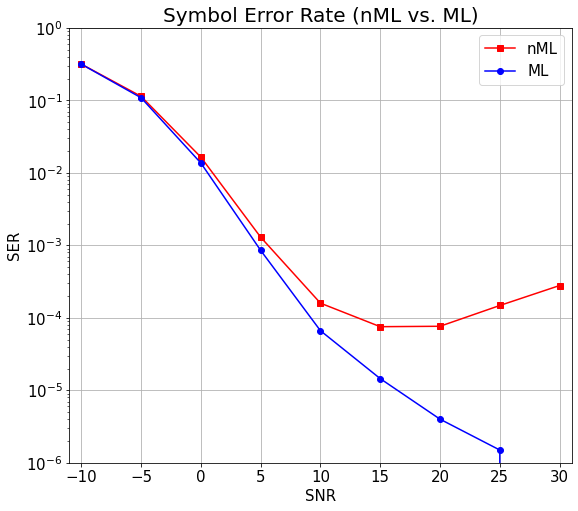

In [24]:
plt.figure(figsize=(9, 8))
plt.semilogy(snr_lst, sers_avg[:, 0], '-rs', label='nML')
# plt.semilogy(snr_lst, sers[:, 1])
plt.semilogy(snr_lst, sers_avg[:, 2], '-bo', label='ML')
plt.xlim([-11, 31]); plt.ylim([1e-6, 1])
plt.xticks(fontsize=15); plt.xlabel("SNR", fontsize=15)
plt.yticks([1e-0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6], fontsize=15); plt.ylabel("SER", fontsize=15)
plt.grid(); plt.legend(fontsize=15); plt.title("Symbol Error Rate (nML vs. ML)", fontsize=20)
plt.show()

[3.1611295e-01 1.0877510e-01 1.3768750e-02 8.8650000e-04 7.5050000e-05
 1.4250000e-05 4.6000000e-06 2.9500000e-06]


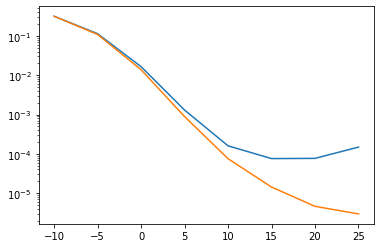

In [38]:
import os 


sers_avg_nML = sers_avg[:-1, 0]
save_dir = './results/'
load_fname = "sers_avg_ml.npy"

plt.semilogy(snr_lst[:-1], sers_avg_nML)
sers_avg_ml = np.load(save_dir+load_fname)
print(sers_avg_ml)
plt.semilogy(snr_lst[:-1], sers_avg_ml)

plt.show()

In [40]:
np.save(save_dir + "sers_avg_nML.npy", sers_avg_nML) 

del sers_avg_nML

### load saved results zf to nML (one-stage)

In [98]:
def loadf(fname: str, load_dir='./results/'):
    if load_dir == None:    
        load_dir = "./results/"
    fname = fname
    fdir = os.path.join(load_dir, fname)
    print(fdir)
    return np.load(fdir)
    
def get_all_results(load_dir='./results/'):
    fnames = None 
    for dir_path, dir_names, fname in os.walk(load_dir):
        fnames = fname
    return fnames 

def load_all_results(load_dir='./results/'):
    results_key = get_all_results()
    print(results_key)
    results_value = [loadf(i) for i in results_key]
    print(results_value)
    return results_key, results_value
# fnames_lst = None 
# for dir_path, dir_names, fnames in os.walk(save_dir):
#     fnames_lst = fnames
#     print(fnames)

# results = [loadf(i) for i in fnames_lst]

_, results = load_all_results()


['sers_avg_1_bit_zero_forcing.npy', 'sers_avg_conventional_zero_forcing.npy', 'sers_avg_bmmse.npy', 'sers_avg_nML.npy', 'sers_avg_ml.npy']
./results/sers_avg_1_bit_zero_forcing.npy
./results/sers_avg_conventional_zero_forcing.npy
./results/sers_avg_bmmse.npy
./results/sers_avg_nML.npy
./results/sers_avg_ml.npy
[array([24.3565  , 22.5931  , 21.04425 , 19.823975, 18.76425 , 17.778075,
       17.114625, 16.5105  , 16.05255 , 15.684175, 15.341875, 15.0935  ,
       14.88915 , 14.7787  , 14.625675, 14.5541  , 14.468375, 14.380775,
       14.319275, 14.307775, 14.2702  , 14.2239  , 14.234125, 14.205525,
       14.1941  , 14.19065 , 14.17255 , 14.177675, 14.1812  , 14.16225 ]), array([0.487287  , 0.42303433, 0.36221567, 0.30699667, 0.25830267,
       0.21352567, 0.17606067, 0.14542167, 0.11794633, 0.09514767,
       0.07791   , 0.06264733, 0.05019667, 0.03999967, 0.03258333,
       0.02566367, 0.020709  , 0.01652433, 0.01316167, 0.01043867,
       0.00825033, 0.006773  , 0.005135  , 0.004027 

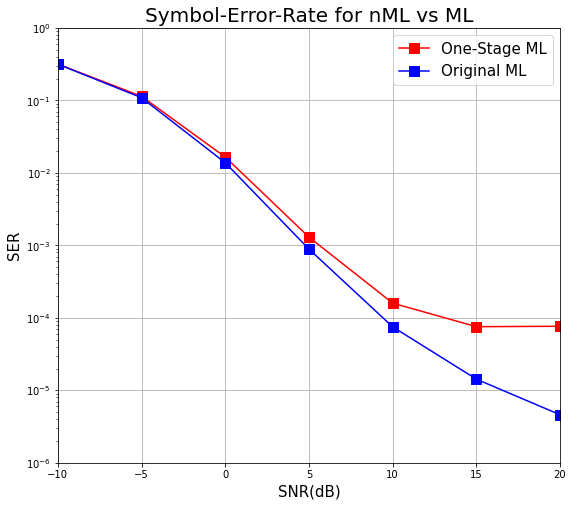

In [99]:
plt.figure(figsize=(9, 8))
# plt.semilogy(snr_lst[1:], results[2], '-s', )
plt.semilogy(snr_lst[:-1], results[3], '-rs', markersize=10, label='One-Stage ML')
plt.semilogy(snr_lst[:-1], results[4], '-bs', markersize=10, label='Original ML')
plt.xlim([-10, 20]); plt.ylim([1e-6, 1e0])
plt.xlabel("SNR(dB)", fontsize=15); plt.ylabel("SER", fontsize=15); plt.title("Symbol-Error-Rate for nML vs ML", fontsize=20)
plt.grid(); plt.legend(fontsize=15)
plt.show()

In [87]:
num1 = np.matmul(G_tilde.T, np.ones_like(y_re))
denom1 = np.linalg.norm(num1)
x_init = (np.sqrt(K) * (num1 / denom1))

array([[-0.64381541],
       [-0.34996612],
       [ 1.02095044],
       [-0.64860283]])

In [64]:
test = np.exp(-(10**(snr/20))*(-1.949)**2)
test = np.sqrt(2 * (10**(0/20))) * -1.949
test = phi(test)
print(test)

0.002922947624310668


In [67]:
GD(x_init=x_init, snr=1, epoch=100, lr=0.01)

inner product term: [[-0.19563831]
 [ 0.44242915]
 [-1.9493769 ]
 [-0.69808852]
 [-0.51312635]
 [-0.78845971]
 [-1.05735653]
 [-0.22458081]]
numerator [[0.95796453]
 [0.80281748]
 [0.01406946]
 [0.57880448]
 [0.74421453]
 [0.49781649]
 [0.2852413 ]
 [0.94498075]]
denominator:  [[0.38473496]
 [0.74625906]
 [0.0017491 ]
 [0.14783956]
 [0.22104495]
 [0.11877727]
 [0.05660463]
 [0.36827538]]
cost= -14.402207791731316
inner product term: [[-0.14351316]
 [ 0.47931024]
 [-1.68269774]
 [-0.59581145]
 [-0.41459199]
 [-0.64429602]
 [-0.88247907]
 [-0.19130747]]
numerator [[0.97715585]
 [0.77277247]
 [0.04171212]
 [0.67145601]
 [0.82459754]
 [0.62765204]
 [0.41736525]
 [0.95976747]]
denominator:  [[0.41488978]
 [0.76362506]
 [0.00585609]
 [0.1860539 ]
 [0.26727897]
 [0.16723171]
 [0.09309018]
 [0.3872167 ]]
inner product term: [[-0.0970127 ]
 [ 0.51348469]
 [-1.44436824]
 [-0.50424172]
 [-0.32592349]
 [-0.51515046]
 [-0.72472409]
 [-0.16113348]]
numerator [[0.98949572]
 [0.7439074 ]
 [0.09625499]

([-14.402207791731316,
  -12.296026079763848,
  -10.59150704836453,
  -9.204191644455365,
  -8.068285851374654,
  -7.132435874664075,
  -6.356466674718757,
  -5.708864869492898,
  -5.164836420978259,
  -4.704807838601627,
  -4.313269359478618,
  -3.977881625414508,
  -3.6887852624082242,
  -3.4380666350166207,
  -3.219343788746179,
  -3.027444901557717,
  -2.8581579799351697,
  -2.7080354771006965,
  -2.574241310727558,
  -2.4544306732686545,
  -2.346655261809676,
  -2.2492882636598006,
  -2.160964740984527,
  -2.080534057183035,
  -2.007021752165607,
  -1.93959885897078,
  -1.8775571028991829,
  -1.8202887690175953,
  -1.7672702892178398,
  -1.7180488047824274,
  -1.6722311188789452,
  -1.6294745764165817,
  -1.5894795044912096,
  -1.5519829214926353,
  -1.5167532816312204,
  -1.4835860678147033,
  -1.4523000822670649,
  -1.4227343131772152,
  -1.3947452786491388,
  -1.368204767573018,
  -1.3429979117369268,
  -1.3190215353185397,
  -1.2961827374340378,
  -1.2743976711447416,
  -1.253

In [344]:
x_tilde = x_tilde_re[:K] + 1j * x_tilde_re[K:]
x_det_first_stage = symbol_by_symbol(x_tilde=x_tilde, constellation_points=constellation_points)
x_det_first_stage, x[:K] + 1j * x[K:]

(array([[-0.70710678-0.70710678j],
        [-0.70710678-0.70710678j]]),
 array([[-0.70710678+0.70710678j],
        [ 0.70710678+0.70710678j]]))

In [232]:
K = 2   # Number of users (transmitter antenna) 
N = 16   # Number of Receiver (Receive antenna)
M = 4   # level of modulation (4-QAM / QPSK)
T = 10 # Total Transmission rounds 
SNR_max = 30


def make_symbol_space(K, M, cp):
    """
    Makes symbol space S = |M|^K 
    :params: 
    :   K (int) : number of users\n
    :   M (int) : level of modulation\n
    :returns:
    :   symbol_space (np.ndarray) : symbol space S=|M|^K
    """
    index_space = np.indices([M for _ in range(K)]).reshape(K, -1).T 
    symbol_space = np.take(cp, index_space)
    return symbol_space 

def comp2re(H, x, z, y):
    """
    Real representation of complex matrix \n
    \t x = [x_r + j x_i] --->  x_re = [x_re x_im] \n
    \t H_re = \n \t \t[H_real, -H_imag \n
        \t H_imag, H_real]\n
    
    """
    x_re = np.hstack((x.real, x.imag))
    z_re = np.hstack((z.real, x.imag))
    y_re = np.hstack((y.real, y.imag)) 
    H_re = np.block([
        [H.real, -H.imag],
        [H.imag, H.real]
    ])
    return H_re, x_re, z_re, y_re 

def initialize(G_tilde, y_re):
    num1 = np.matmul(G_tilde.transpose(0, 2, 1), np.ones_like(y_re))
    denom1 = np.linalg.norm(num1, axis=1).reshape(-1, 1, 1)
    x_init = (num1 / denom1) * np.sqrt(K)
    return x_init


snr = 5

# simple constellation points (normalized)
constellation_points = np.array([-1-1j, -1+1j, 1-1j, 1+1j])
constellation_points /= np.sqrt(2) 

# make symbol space = |M|^K  in case of using ML detection 
symbol_space = make_symbol_space(K, M, cp=constellation_points) 

x = np.random.randint(0, M, size=K * T).reshape(T, K, 1) 
x = np.take(constellation_points, x)

# Channel 
H = (1 / np.sqrt(2)) * (np.random.randn(T, N, K) + 1j * np.random.randn(T, N, K))
z = (1 / np.sqrt(2)) * (np.random.randn(T, N, 1) + 1j * np.random.randn(T, N, 1))

r = np.matmul(H, x) + (10**(-snr/20)) * z  

# 1-bit ADC 
y = np.sign(r.real) + 1j * np.sign(r.imag) 

H_re, x_re, z_re, y_re = comp2re(H, x, z, y)

G_tilde = H_re * y_re 

x_init = initialize(G_tilde=G_tilde, y_re=y_re)
x_init.shape

(10, 4, 1)

(10, 32, 8)

In [ ]:
def cost(G_tilde, x_init, snr):
    snr = 10 ** (snr/20) 
    g = np.sqrt(2 * snr) * (G_tilde @ x_init) 
    g = phi(g) 
    g = np.log(g) 
    g = np.sum(g) 
    return g



In [224]:
def initialize(G_tilde, y_re):
    num1 = np.matmul(G_tilde.transpose(0, 2, 1), np.ones_like(y_re))
    denom1 = np.linalg.norm(num1, axis=1).reshape(-1, 1, 1)
    x_init = (num1 / denom1) * np.sqrt(K)
    return x_init



array([[1.41421356],
       [1.41421356],
       [1.41421356],
       [1.41421356],
       [1.41421356],
       [1.41421356],
       [1.41421356],
       [1.41421356],
       [1.41421356],
       [1.41421356]])

In [21]:
x = x_re[0]; y = y_re[0]; H = H_re[0]
x_tilde.shape, x.shape, y.shape, H.shape

((8, 1), (8, 1), (32, 1), (32, 8))

In [22]:
x_det = nML(y_re=y, H_re=H, x_init=x_tilde, snr_dB=5, symbol_space=constellation_points, iter=10)

ValueError: axes don't match array